In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os

# Configure pararmters

In [2]:
gridPath = "FL_1km_Grid/FL_1km_Grid.shp"
gridID = "id"
metaPath = "ALL_FL_Predictions_Thresholds_NLCD2023_RF_CorrectPred_combined.csv"
predLabel = "RF_Correct_Pred"
savePath = "PUD_Res"

# Data preprocessing

In [74]:
#"../RF_CLIP_BinaryClass_Other&CES_RunAllFL/CLIP_RF_RunFL//ALL_FL_Predictions_Thresholds_NLCD2023_RF_CorrectPred_combined.csv"
metadata = pd.read_csv(
    metaPath
)

# keep only selected years
metadata["takendate"] = pd.to_datetime(metadata["takendate"], errors="coerce")
selected_years = [2014, 2015, 2016, 2017, 2018, 2019]
metadata = metadata[metadata.takendate.dt.year.isin(selected_years)]

# build GeoDataFrame with correct CRS (WGS84 degrees)
geo_df = gpd.GeoDataFrame(
    metadata,
    geometry=gpd.points_from_xy(metadata.longitude, metadata.latitude),
    crs="EPSG:4326"
)

/scratch/local/14203295/ipykernel_1129514/2531897348.py:1: DtypeWarning: Columns (14,139,140) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(


In [75]:
grid_gdf = gpd.read_file(gridPath)

In [76]:
grid_gdf[gridID] = grid_gdf[gridID].astype(str)

# reproject points to grid CRS (UTM meters)
geo_df = geo_df.to_crs(grid_gdf.crs)

# spatial join
joined_gdf = gpd.sjoin(geo_df, grid_gdf, how="left", predicate="within")

In [78]:
len(joined_gdf)

590378

In [107]:
joined_gdf.drop(columns='geometry').to_csv("ALL_FL_Predictions_Thresholds_NLCD2023_RF_CorrectPred_combined_1kmGrids.csv", index=False)

In [83]:
#Add PUD_ID column
joined_gdf['PUD_ID'] = joined_gdf['ownerid'].astype(str) + '_' + joined_gdf['takendate'].astype(str) + '_' + joined_gdf[gridID].astype(str)
joined_gdf['ownerid_ID'] = joined_gdf['ownerid'].astype(str) + '_' + joined_gdf[gridID].astype(str)
joined_gdf[gridID] = joined_gdf[gridID].astype(str)

In [84]:
# Print just the column names
print(joined_gdf.columns)

# Or view the first few rows to check both column names and some values
print(joined_gdf.head())

Index(['Unnamed: 0', 'photoid', 'ownerid', 'latitude', 'longitude',
       'uploaddate', 'takendate', 'tags', 'title', 'locaccuracy',
       ...
       'RF_Correct_Pred', 'geometry', 'index_right', 'id', 'left', 'top',
       'right', 'bottom', 'PUD_ID', 'ownerid_ID'],
      dtype='object', length=203)
   Unnamed: 0      photoid       ownerid   latitude  longitude  uploaddate  \
0           0  22788518788  93689361@N05  26.775293 -80.139687  2016-11-13   
1           1  22790832128  13552664@N03  28.415787 -81.574615  2016-11-13   
2           2  22792116518  26678134@N04  28.419472 -81.582664  2016-11-13   
3           3  22792119418  26678134@N04  28.417894 -81.583611  2016-11-13   
4           4  22806910198  63805593@N04  27.772512 -82.637871  2016-11-14   

   takendate                                               tags  \
0 2016-11-13  animal;animals;bird;birds;birdwatcher;everglad...   
1 2016-10-27                                                NaN   
2 2016-11-13             d

In [30]:
joined_gdf_excludeNoCES = joined_gdf[joined_gdf[predLable]!='Other']
len(joined_gdf_excludeNoCES)

310773

<h1>Compute Unqiue users and PUD Intenstiy<h1/>

In [104]:
def avgPUDsyearly(years_to_filter, joined_gdf_excludeNoCES, saveName, sta=False):
    
    # parameters
    # gridPath = 'FL_1km_Grid/FL_1km_Grid.shp'
    # gridID = 'id'
    # predLable = 'RF_Correct_Pred' ###par



    # Define the list of years you want to filter
    #years_to_filter = [2014, 2015, 2016, 2017, 2018, 2019]

    # Filter the GeoDataFrame for rows where the year in 'takendate' is in the list of years
    filtered_gdf = joined_gdf_excludeNoCES[joined_gdf_excludeNoCES['takendate'].dt.year.isin(years_to_filter)]

    owner_counts = filtered_gdf.groupby(gridID)['ownerid_ID'].nunique().reset_index(name='unique_owner_counts') ##UniqueOwner
    copy_grid_gdf = grid_gdf.copy()
    gdf_regions_with_counts = copy_grid_gdf.merge(owner_counts, on=gridID, how='left')

    pud_counts = filtered_gdf.groupby(gridID)['PUD_ID'].nunique().reset_index(name='pud_count') ##PUDs
    gdf_regions_with_counts = gdf_regions_with_counts.merge(pud_counts, on=gridID, how='left')



    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf_regions_with_counts.plot(column='pud_count', ax=ax, legend=True, cmap='inferno_r')

    gdf_regions_with_counts['pud_count'] = gdf_regions_with_counts['pud_count'].fillna(0)
    gdf_regions_with_counts['unique_owner_counts'] = gdf_regions_with_counts['unique_owner_counts'].fillna(0)

    # Calculate index
    gdf_regions_with_counts['Total_pud'] = gdf_regions_with_counts['pud_count']
    gdf_regions_with_counts['Total_pud'] = gdf_regions_with_counts['Total_pud'].fillna(0)
    
    gdf_regions_with_counts['Avg_pud'] = gdf_regions_with_counts['pud_count'] / len(years_to_filter)
    gdf_regions_with_counts['Avg_pud'] = gdf_regions_with_counts['Avg_pud'].fillna(0)

    gdf_regions_with_counts['Avg_pud_des'] = gdf_regions_with_counts['pud_count'] / len(years_to_filter) / gdf_regions_with_counts['unique_owner_counts']
    gdf_regions_with_counts['Avg_pud_des'] = gdf_regions_with_counts['Avg_pud_des'].fillna(0)
    
    os.makedirs(f"./{savePath}/PUD_shapefiles/", exist_ok=True)
    gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')
    plt.show()

    if sta:
        # Define the list of years you want to filter
        Res = {'Year':[],'Jan.-Mar.':[],'Apr.-Jun.':[],'Jul.-Sep.':[],'Oct.-Dec.':[]}
        month_to_filter = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]
        for m in month_to_filter:
            # Filter the GeoDataFrame for rows where the year in 'takendate' is in the list of years
            filtered_month_gdf = joined_gdf_excludeNoCES[joined_gdf_excludeNoCES['takendate'].dt.month.isin(m)]
            for y in years_to_filter:
                year_month_df = filtered_month_gdf[filtered_month_gdf['takendate'].dt.year == y]
                unique_pud_count = year_month_df['ownerid_ID'].nunique()
                #print(m, len(year_month_df))
                if y not in Res['Year']:
                    Res['Year'].append(y)
                if m == [1,2,3]:
                    Res['Jan.-Mar.'].append(unique_pud_count)
                if m == [4,5,6]:
                    Res['Apr.-Jun.'].append(unique_pud_count)
                if m == [7,8,9]:
                    Res['Jul.-Sep.'].append(unique_pud_count)
                if m == [10,11,12]:
                    Res['Oct.-Dec.'].append(unique_pud_count)
                    
        os.makedirs(f"./{savePath}/PUD_Metadata/", exist_ok=True)
        pd.DataFrame(Res).to_excel(f'{savePath}/PUD_Metadata/UniqueOwner_{saveName}_count_year_month.xlsx', index=False)

        # Define the list of years you want to filter
        Res = {'Year':[],'Jan.-Mar.':[],'Apr.-Jun.':[],'Jul.-Sep.':[],'Oct.-Dec.':[]}
        month_to_filter = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]
        for m in month_to_filter:
            # Filter the GeoDataFrame for rows where the year in 'takendate' is in the list of years
            filtered_month_gdf = joined_gdf_excludeNoCES[joined_gdf_excludeNoCES['takendate'].dt.month.isin(m)]
            for y in years_to_filter:
                year_month_df = filtered_month_gdf[filtered_month_gdf['takendate'].dt.year == y]
                unique_pud_count = year_month_df['PUD_ID'].nunique()
                #print(m, len(year_month_df))
                if y not in Res['Year']:
                    Res['Year'].append(y)
                if m == [1,2,3]:
                    Res['Jan.-Mar.'].append(unique_pud_count)
                if m == [4,5,6]:
                    Res['Apr.-Jun.'].append(unique_pud_count)
                if m == [7,8,9]:
                    Res['Jul.-Sep.'].append(unique_pud_count)
                if m == [10,11,12]:
                    Res['Oct.-Dec.'].append(unique_pud_count)
        pd.DataFrame(Res).to_excel(f'{savePath}/PUD_Metadata/PUDs_{saveName}_count_year_month.xlsx', index=False)
    

def avgPUDsyearlyEArec(years_to_filter, joined_gdf_excludeNoCES, saveName, predictor):
    class_names = [
        "Biking", "Boating", "Camping", "Fishing", "Hiking", "Horseback_Riding",
        "Hunting", "Shelling", "Surfing", "Swimming", "Wildlife_Viewing",
        "Landscape_Aesthetics", "Other"
    ]

    Res = {'Year': [], 'CES Class': [], 'PUDs': [], 'Unique person': [], 'PUDs per unique person': []}
    
    Res2 = {'Year': years_to_filter}

    for cla in class_names:
        Res2[cla] = []
        for yr in years_to_filter:
            # Filter by year and CES class
            filtered = joined_gdf_excludeNoCES[
                (joined_gdf_excludeNoCES['takendate'].dt.year == yr) &
                (joined_gdf_excludeNoCES[predictor] == cla)
            ]

            unique_pud_count = filtered['PUD_ID'].nunique()
            unique_owner_count = filtered['ownerid_ID'].nunique()
            puds_per_person = unique_pud_count / unique_owner_count if unique_owner_count else 0

            Res['Year'].append(yr)
            Res['CES Class'].append(cla)
            Res['PUDs'].append(unique_pud_count)
            Res['Unique person'].append(unique_owner_count)
            Res['PUDs per unique person'].append(puds_per_person)
            Res2[cla].append(puds_per_person)

    pd.DataFrame(Res).to_excel(f'PUDs_density_{saveName}_count_yearly_part1_.xlsx', index=False)
    pd.DataFrame(Res2).to_excel(f'PUDs_density_{saveName}_count_yearly_part2_.xlsx', index=False)

            

In [86]:
joined_gdf_excludeNoCES = joined_gdf[joined_gdf[predLable]!='Other']
len(joined_gdf_excludeNoCES), predLable

(310773, 'RF_Correct_Pred')

In [88]:
years_to_filter = [2014, 2015, 2016, 2017, 2018, 2019]
avgPUDsyearlyEArec(years_to_filter, joined_gdf, 'OverAll_201401-201912', predLable)

In [93]:
joined_gdf_onlyHumanAct = joined_gdf[
    (joined_gdf[predLable] != 'Wildlife_Viewing') &
    (joined_gdf[predLable] != 'Landscape_Aesthetics') &
    (joined_gdf[predLable] != 'Other')
]
len(joined_gdf_onlyHumanAct)

71486

In [90]:
joined_gdf_wildlife = joined_gdf[joined_gdf[predLable] == 'Wildlife_Viewing']
len(joined_gdf_wildlife)

172154

In [91]:
joined_gdf_landscae = joined_gdf[joined_gdf[predLable] == 'Landscape_Aesthetics']
len(joined_gdf_landscae)

67133

In [29]:
#avgPUDsyearly([2018], joined_gdf_wildlife, 'Overallwildlife_2018_test')
#avgPUDsyearly([2019], joined_gdf_wildlife, 'Overallwildlife_2019_test')

In [30]:
joined_gdf_onlyHumanAct.columns

Index(['Unnamed: 0', 'photoid', 'ownerid', 'latitude', 'longitude',
       'uploaddate', 'takendate', 'tags', 'title', 'locaccuracy',
       ...
       'BLKGRPCE', 'GEOID', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND_right',
       'AWATER_right', 'INTPTLAT', 'INTPTLON', 'PUD_ID'],
      dtype='object', length=208)

/scratch/local/14203295/ipykernel_1129514/3046452213.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')


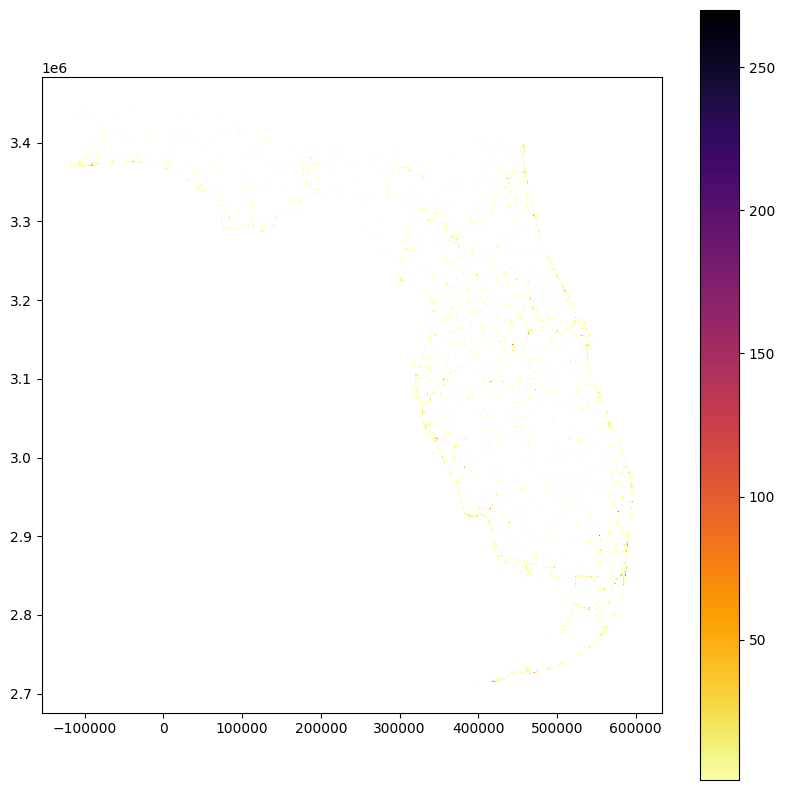

In [111]:
years_to_filter = [2014, 2015, 2016, 2017, 2018, 2019]
avgPUDsyearly(years_to_filter, joined_gdf_onlyHumanAct, 'OverallonlyHumanAct_201401-201912', sta=True)

In [97]:
uni_class

array(['Wildlife_Viewing', 'Other', 'Boating', 'Landscape_Aesthetics',
       'Surfing', 'Swimming', 'Biking', 'Hiking', 'Fishing', 'Camping',
       'Shelling', 'Horseback_Riding', 'Hunting'], dtype=object)

Wildlife_Viewing 172154


/scratch/local/14203295/ipykernel_1129514/3046452213.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')


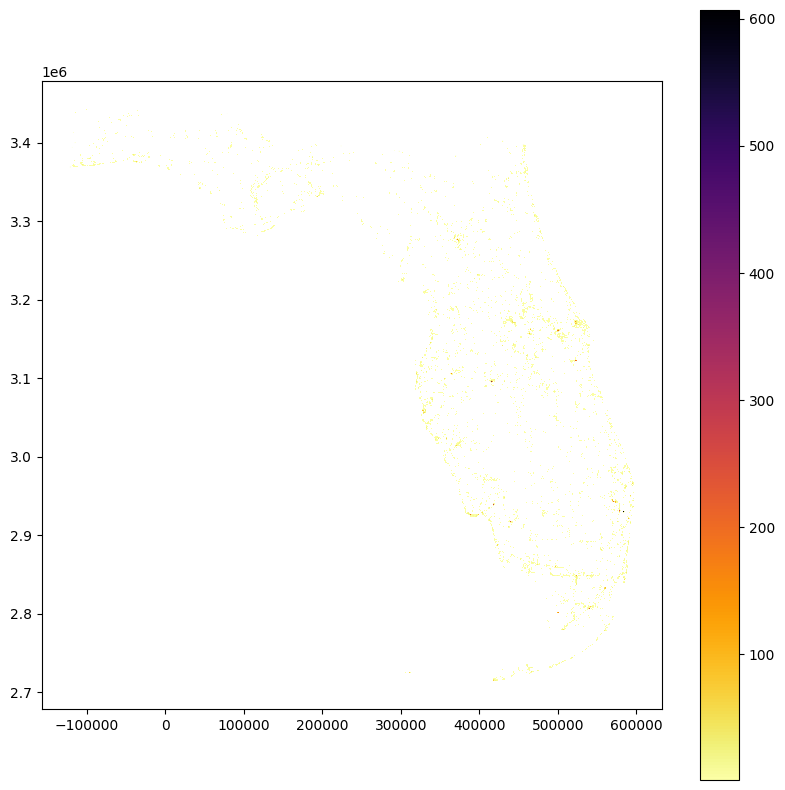

Other 279605


/scratch/local/14203295/ipykernel_1129514/3046452213.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')


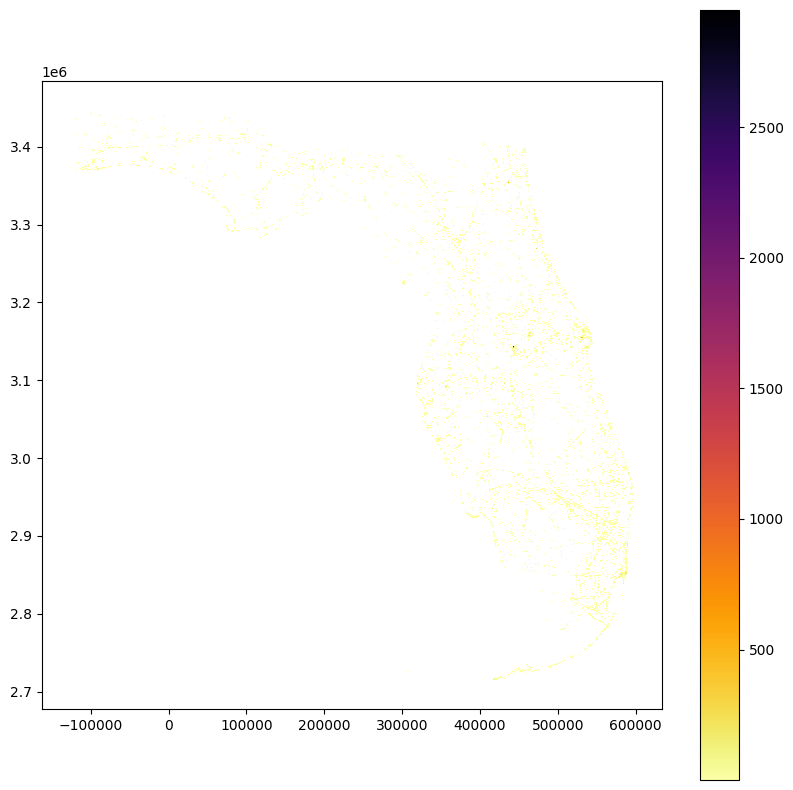

Boating 15491


/scratch/local/14203295/ipykernel_1129514/3046452213.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')


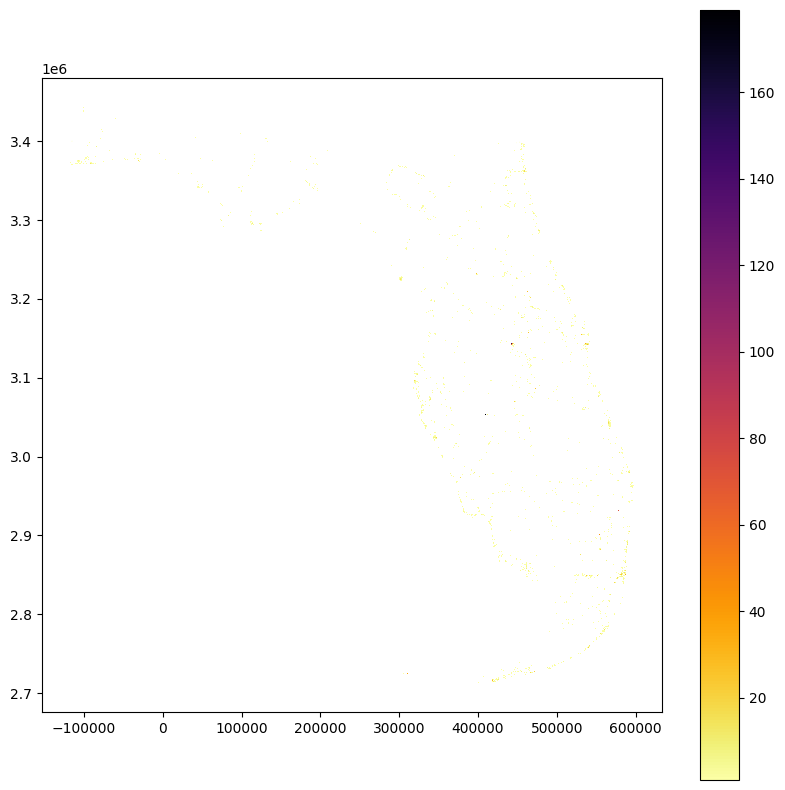

Landscape_Aesthetics 67133


/scratch/local/14203295/ipykernel_1129514/3046452213.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')


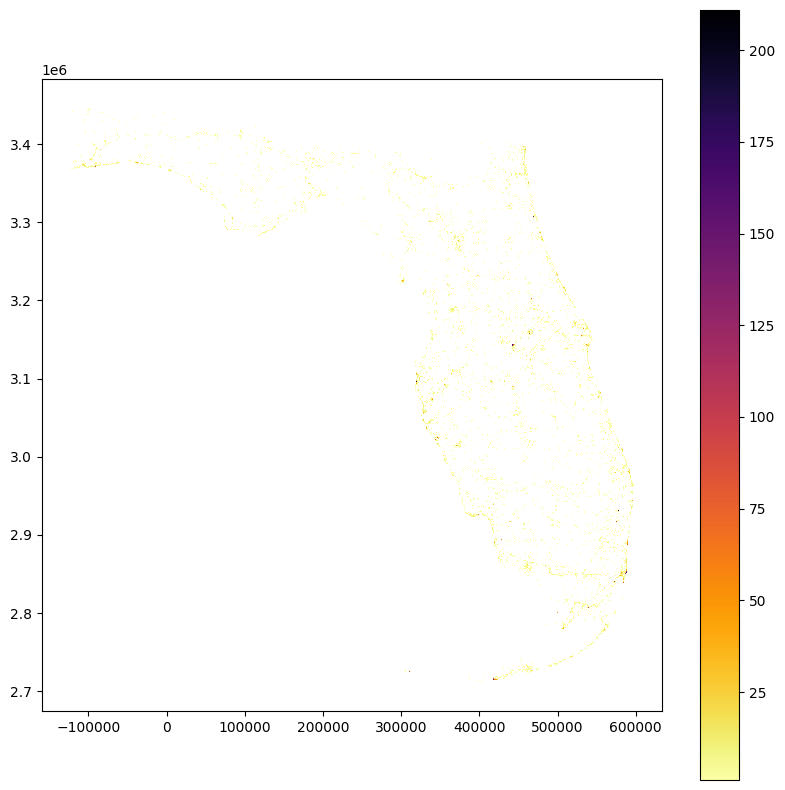

Surfing 5000


/scratch/local/14203295/ipykernel_1129514/3046452213.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')


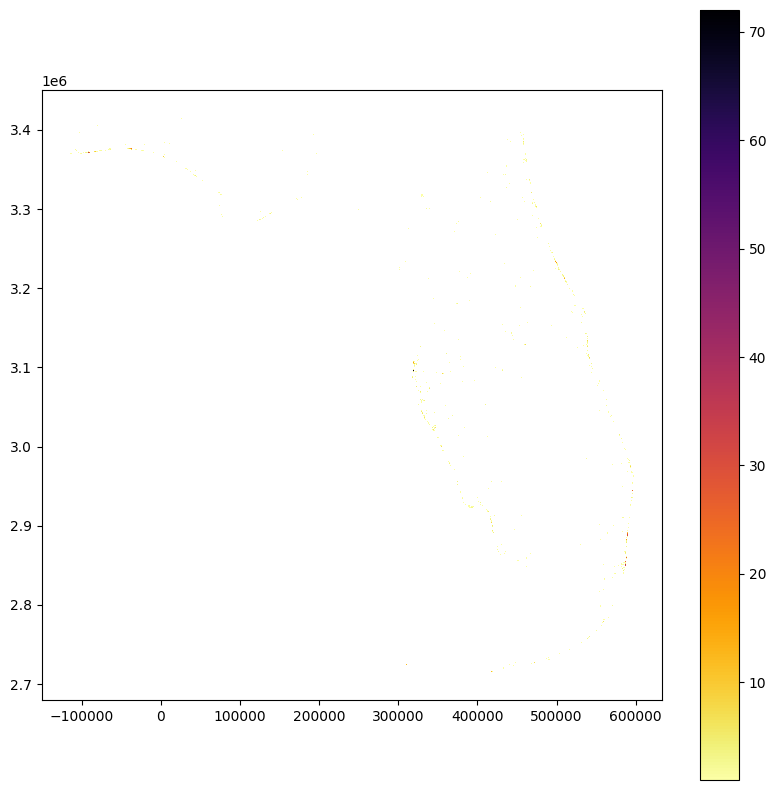

Swimming 14463


/scratch/local/14203295/ipykernel_1129514/3046452213.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')


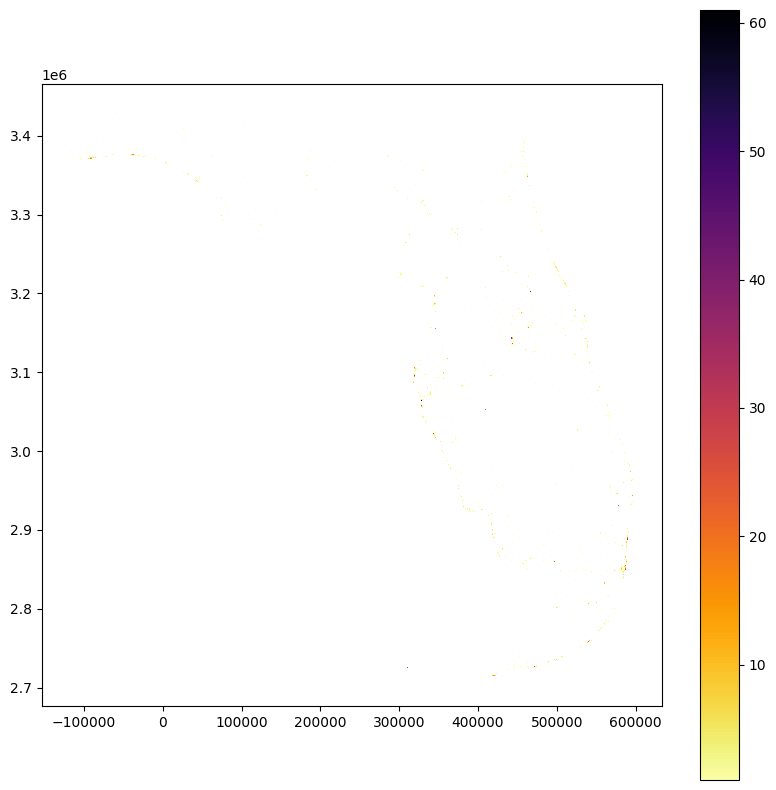

Biking 3360


/scratch/local/14203295/ipykernel_1129514/3046452213.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')


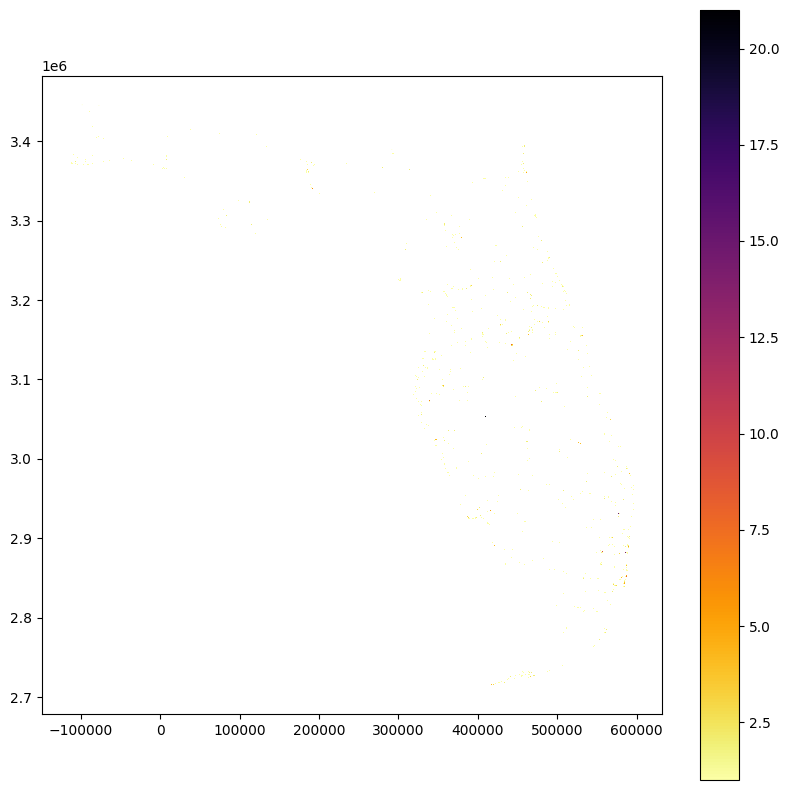

Hiking 6125


/scratch/local/14203295/ipykernel_1129514/3046452213.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')


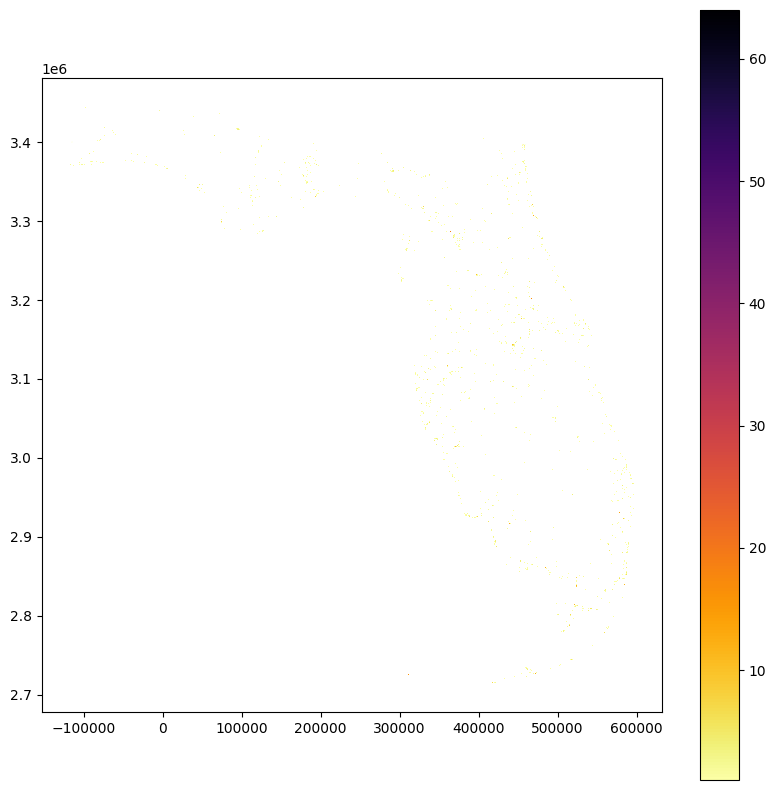

Fishing 6677


/scratch/local/14203295/ipykernel_1129514/3046452213.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')


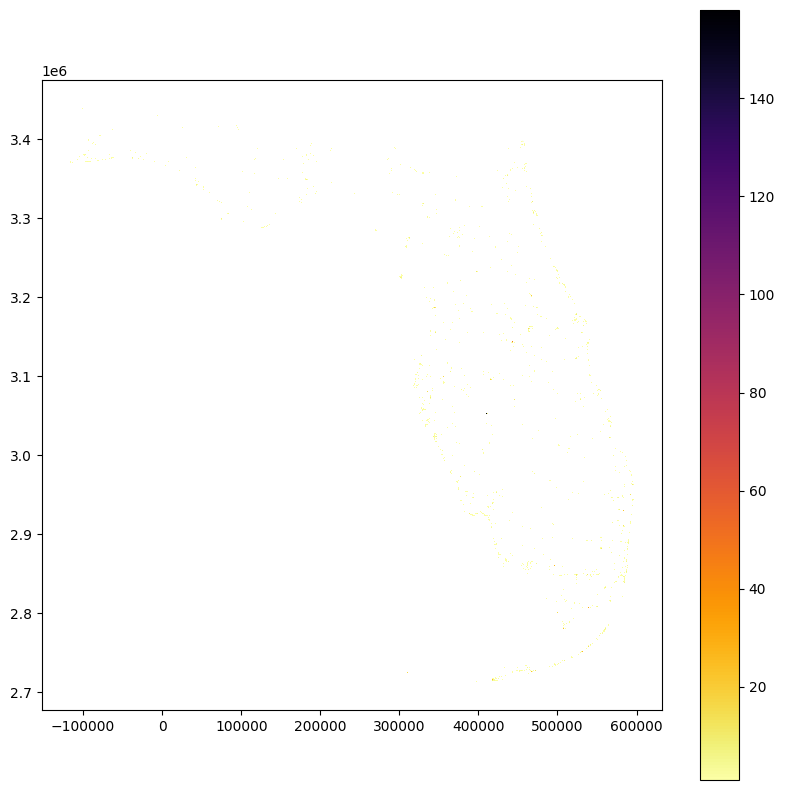

Camping 2435


/scratch/local/14203295/ipykernel_1129514/3046452213.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')


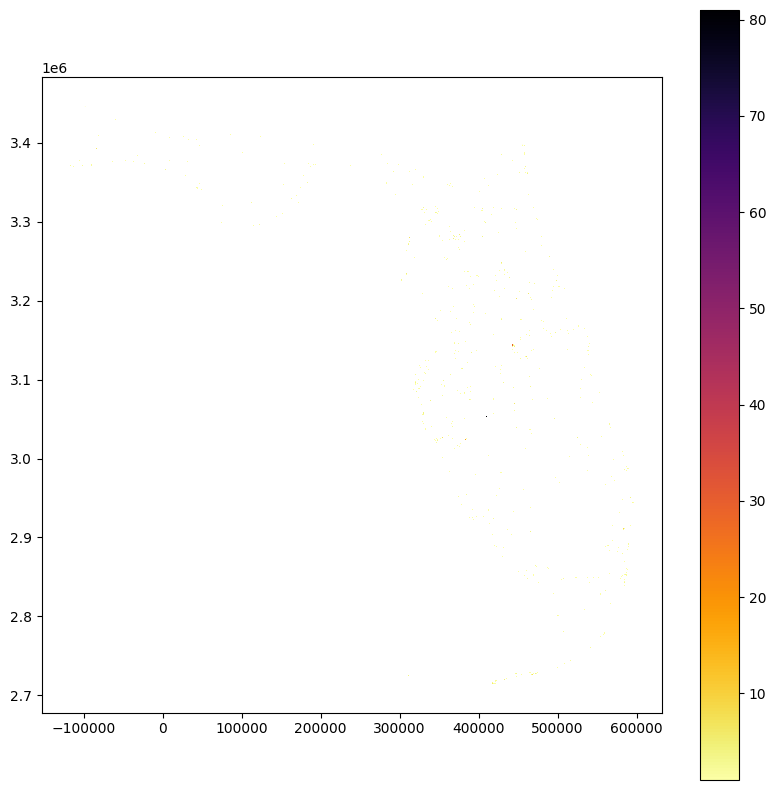

Shelling 11575


/scratch/local/14203295/ipykernel_1129514/3046452213.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')


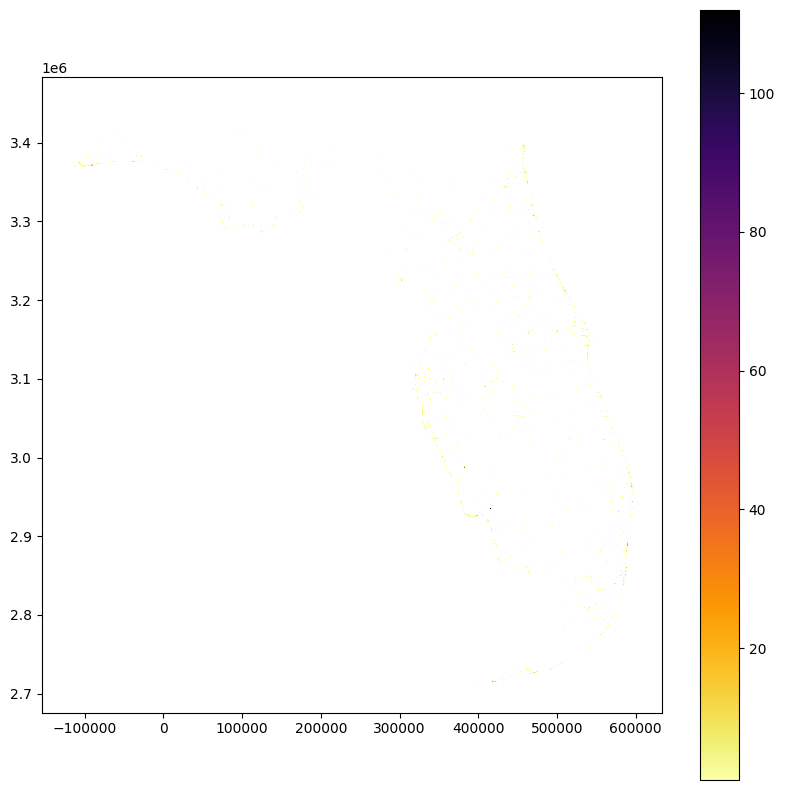

Horseback_Riding 2757


/scratch/local/14203295/ipykernel_1129514/3046452213.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')


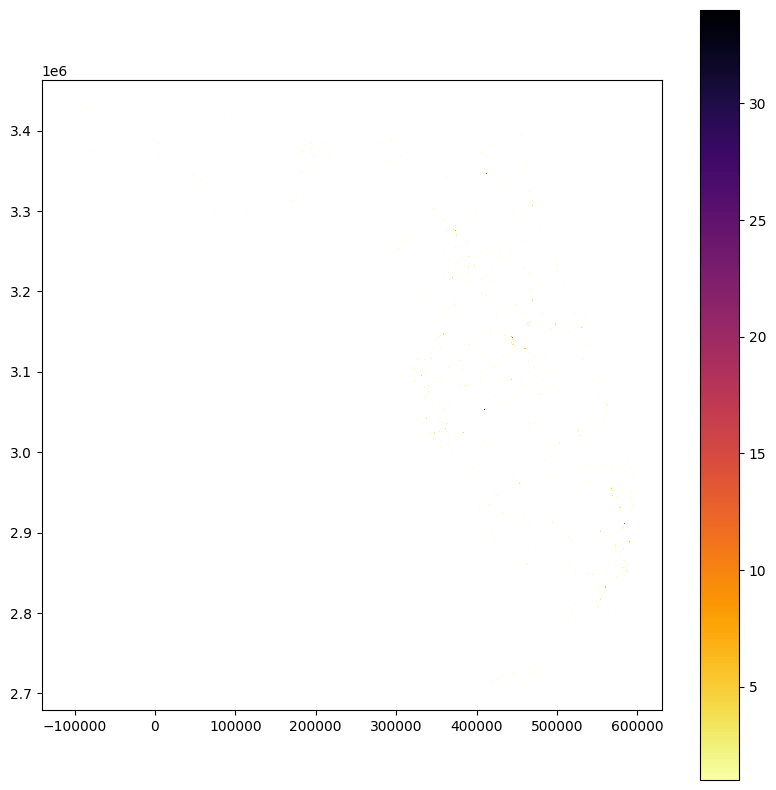

Hunting 3603


/scratch/local/14203295/ipykernel_1129514/3046452213.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')


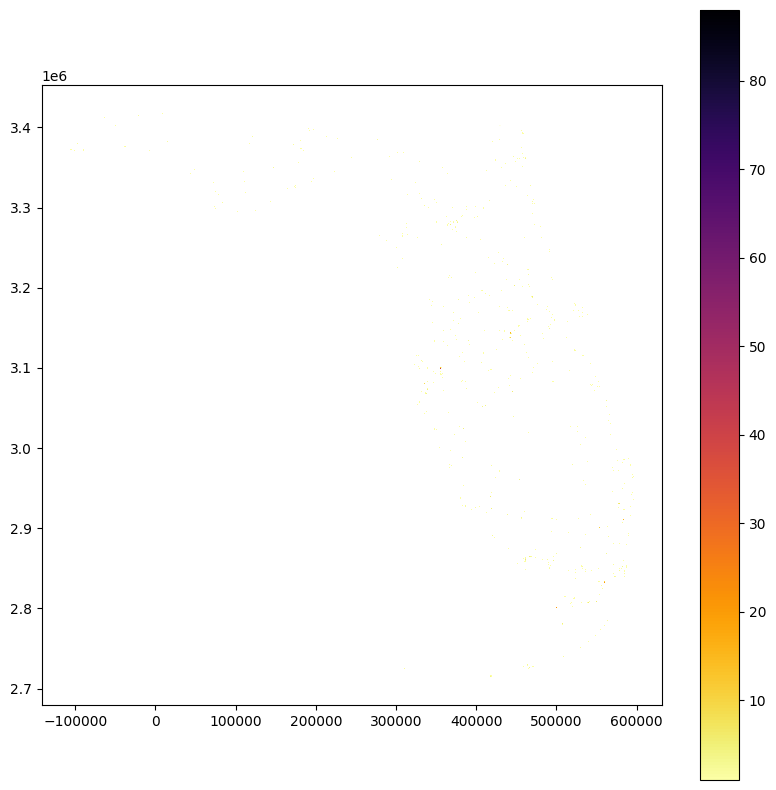

In [105]:
#Considerate each class
for cla in list(uni_class):
    joined_gdf_cla = joined_gdf[joined_gdf[predLable]==cla]
    print(cla, len(joined_gdf_cla))
    avgPUDsyearly(years_to_filter, joined_gdf_cla, f'{cla}_201401-201912', sta=True)

/scratch/local/14203295/ipykernel_1129514/3046452213.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./{savePath}/PUD_shapefiles/PUD_{saveName}.shp', driver='ESRI Shapefile')


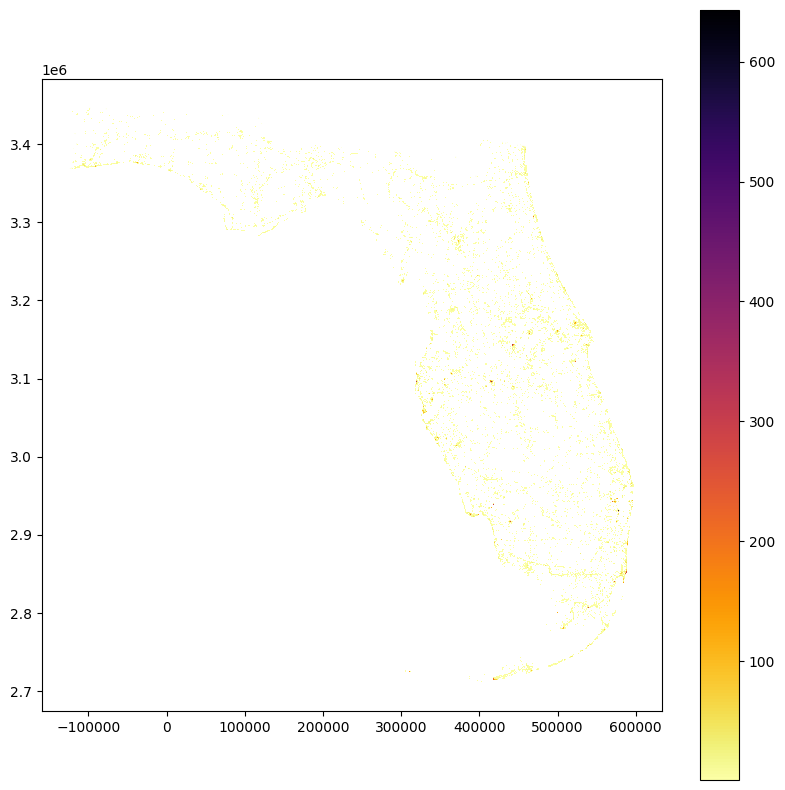

In [109]:
#Total
years_to_filter = [2014, 2015, 2016, 2017, 2018, 2019]
avgPUDsyearly(years_to_filter, joined_gdf_excludeNoCES, f'Total_excludeNoCES_201401-201912', sta=True)

In [112]:
import shutil
shutil.make_archive("PUD_Res", 'zip', "PUD_Res")
print("Zipped")

Zipped


/scratch/local/64522582/ipykernel_3655847/3300049953.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./PUD/PUD_{saveName}.shp', driver='ESRI Shapefile')


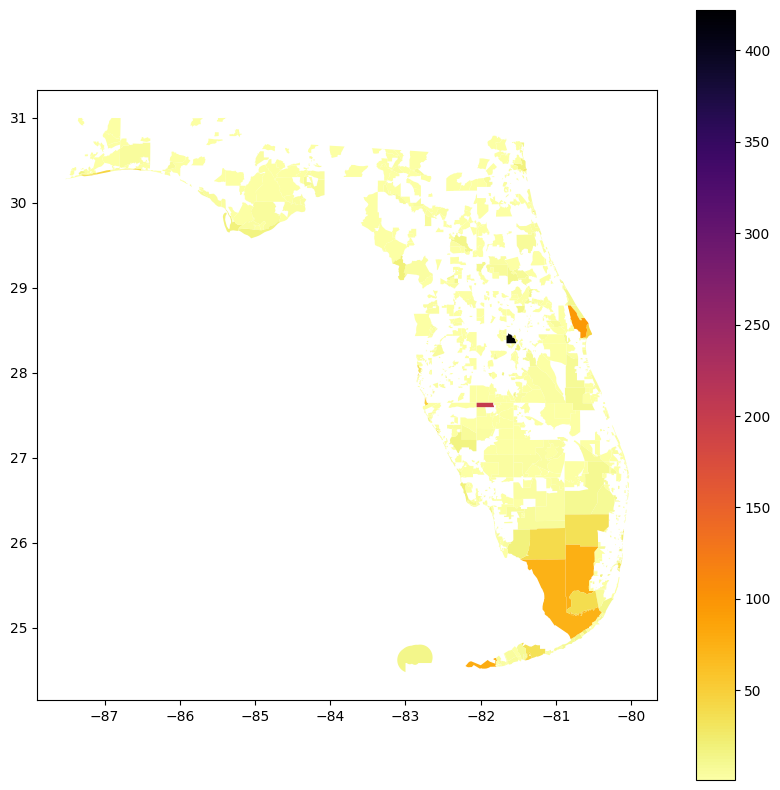

/scratch/local/64522582/ipykernel_3655847/3300049953.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./PUD/PUD_{saveName}.shp', driver='ESRI Shapefile')


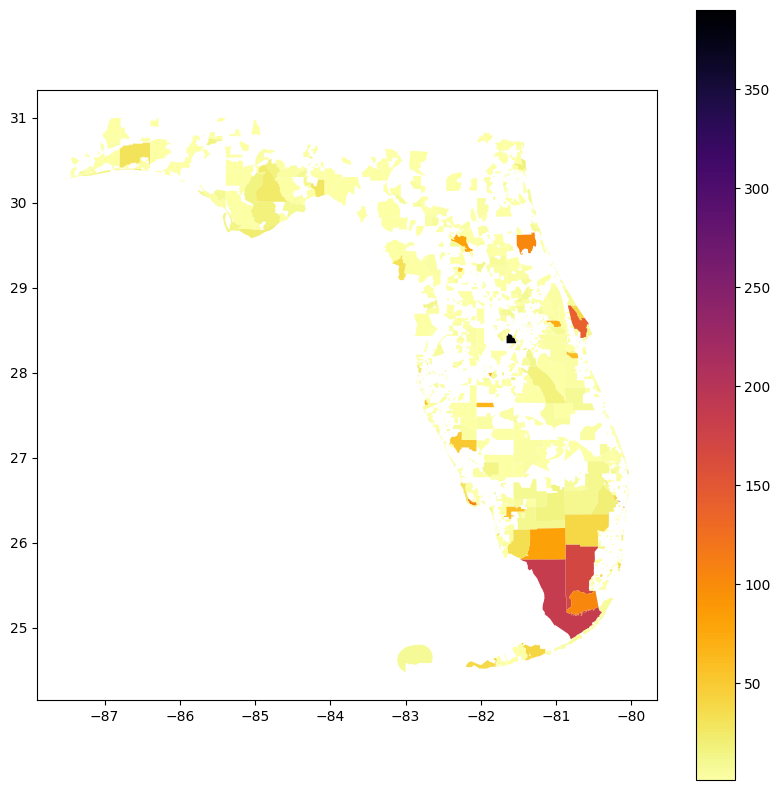

/scratch/local/64522582/ipykernel_3655847/3300049953.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./PUD/PUD_{saveName}.shp', driver='ESRI Shapefile')


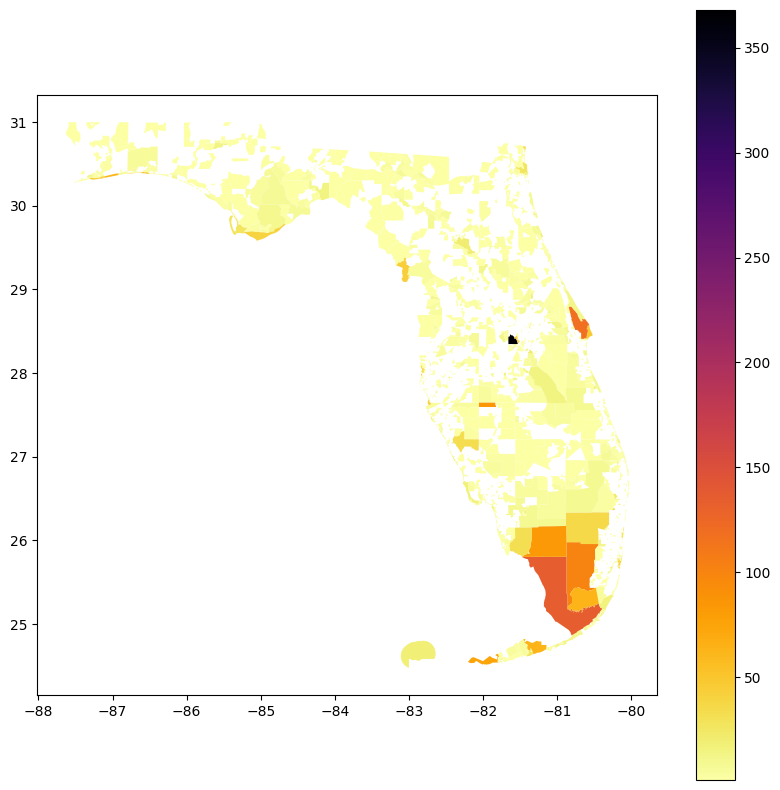

/scratch/local/64522582/ipykernel_3655847/3300049953.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./PUD/PUD_{saveName}.shp', driver='ESRI Shapefile')


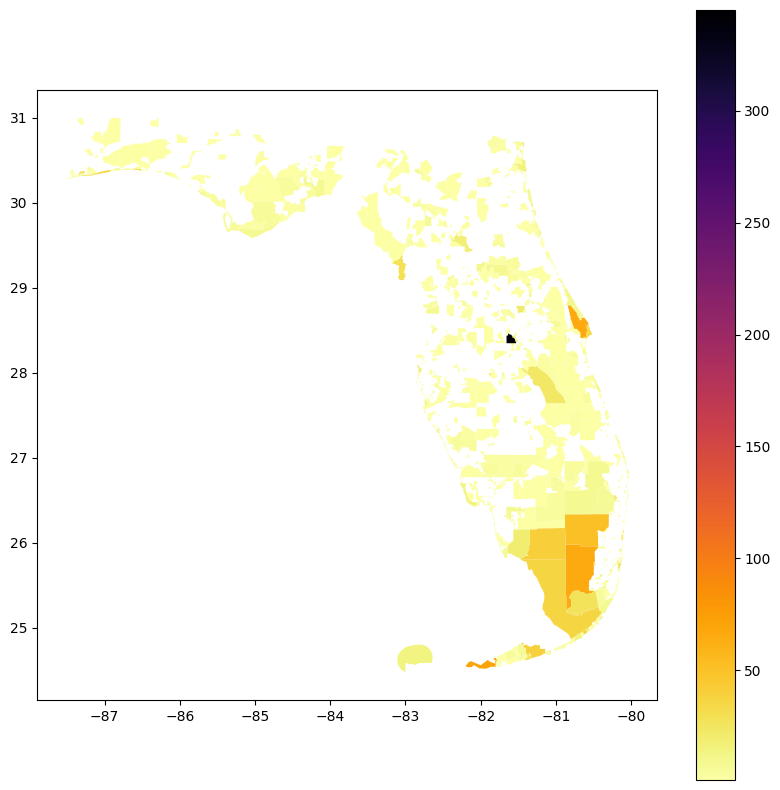

/scratch/local/64522582/ipykernel_3655847/3300049953.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./PUD/PUD_{saveName}.shp', driver='ESRI Shapefile')


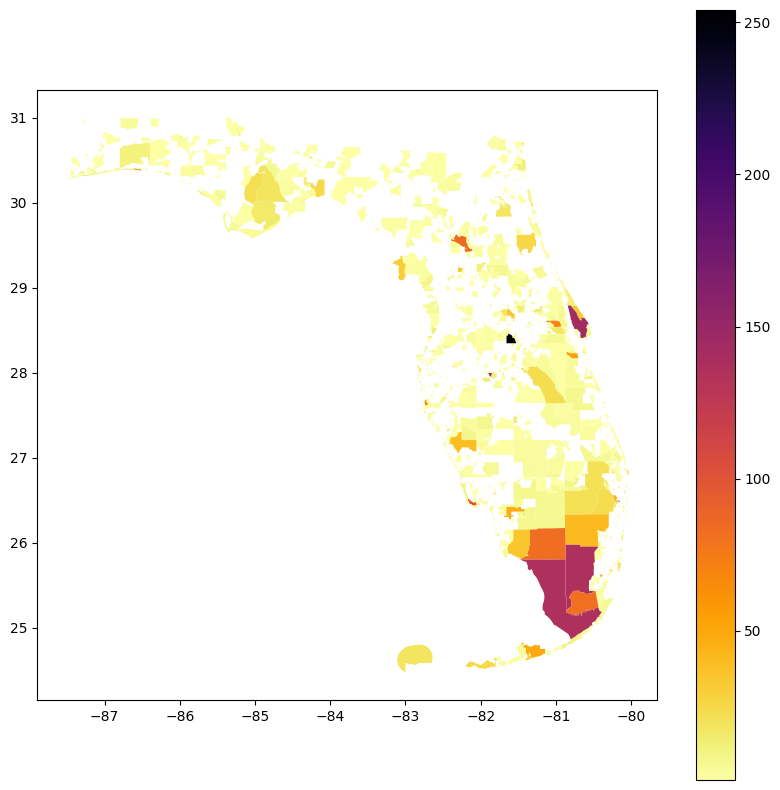

/scratch/local/64522582/ipykernel_3655847/3300049953.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./PUD/PUD_{saveName}.shp', driver='ESRI Shapefile')


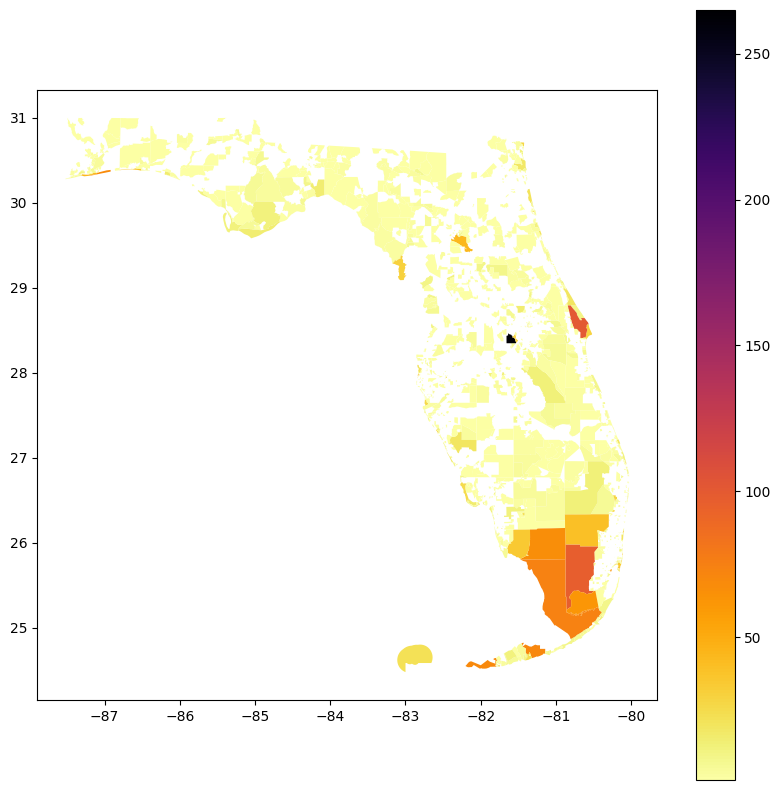

/scratch/local/64522582/ipykernel_3655847/3300049953.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./PUD/PUD_{saveName}.shp', driver='ESRI Shapefile')


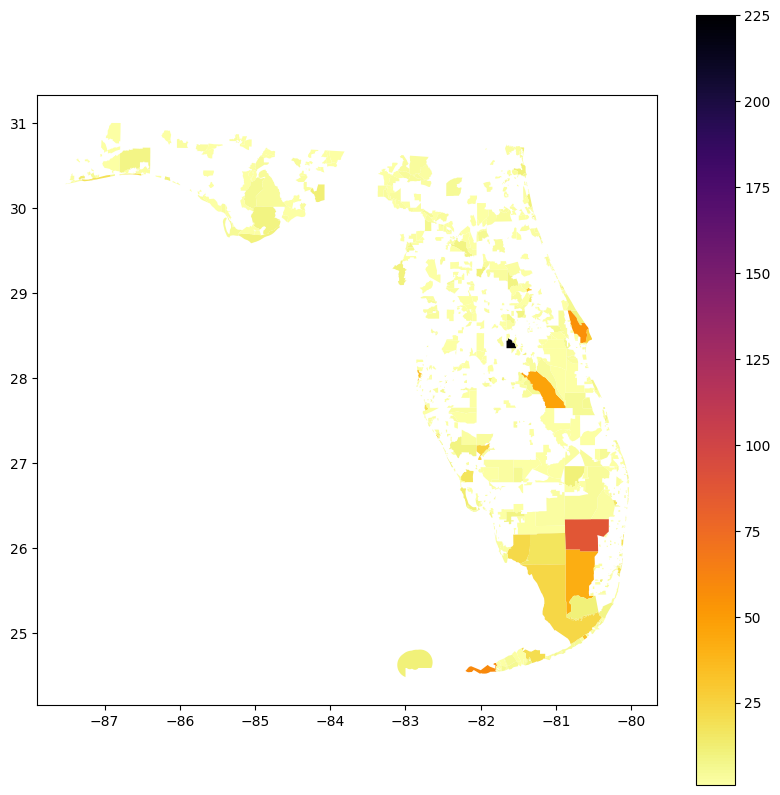

/scratch/local/64522582/ipykernel_3655847/3300049953.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./PUD/PUD_{saveName}.shp', driver='ESRI Shapefile')


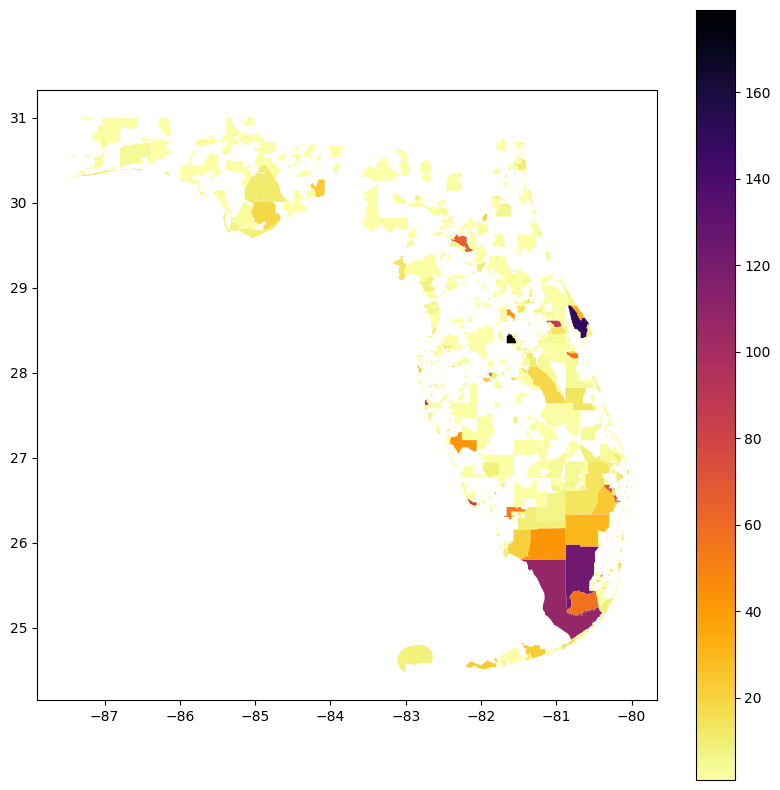

/scratch/local/64522582/ipykernel_3655847/3300049953.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./PUD/PUD_{saveName}.shp', driver='ESRI Shapefile')


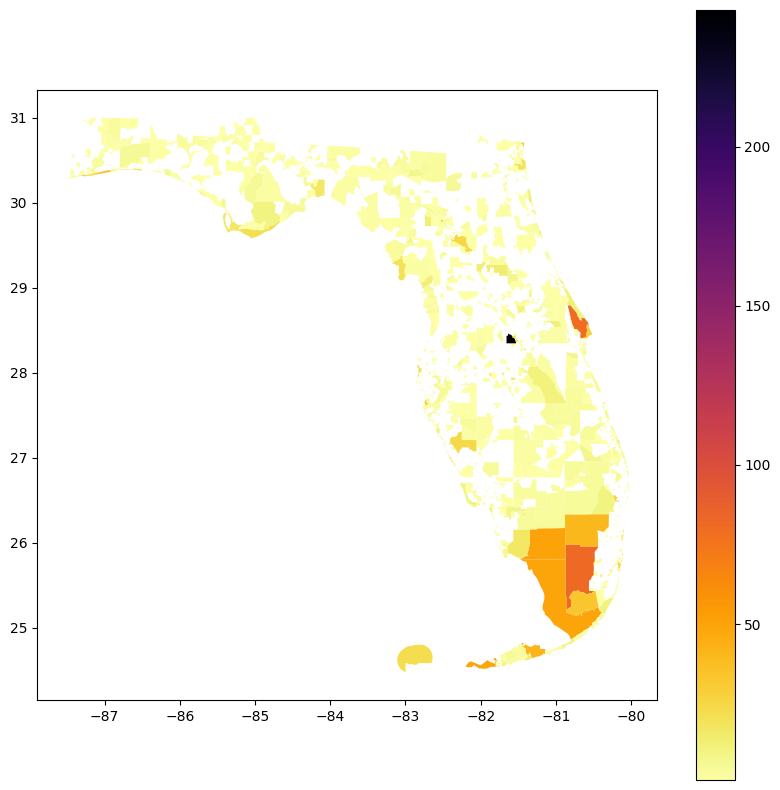

/scratch/local/64522582/ipykernel_3655847/3300049953.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./PUD/PUD_{saveName}.shp', driver='ESRI Shapefile')


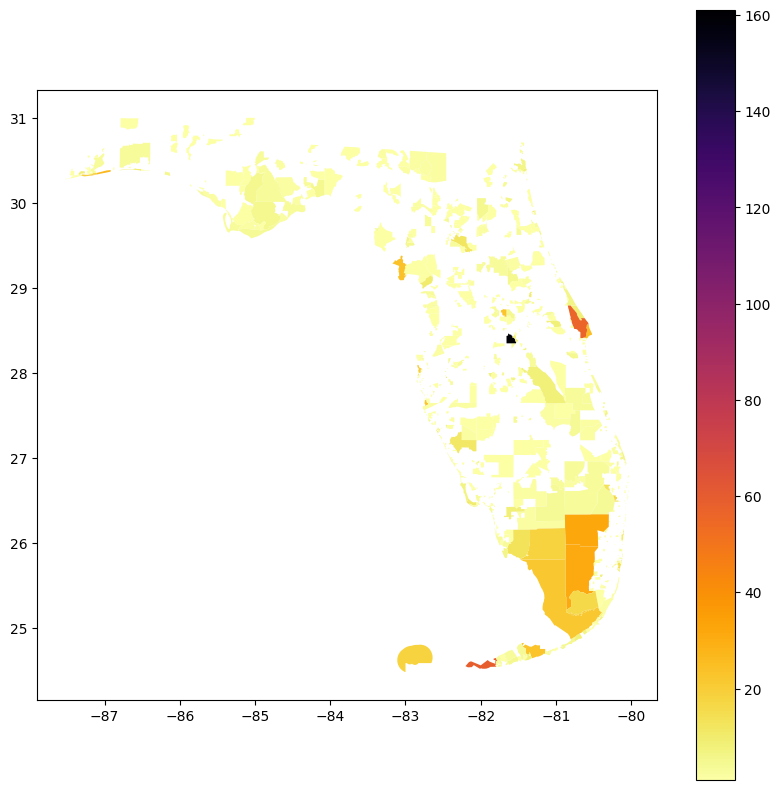

/scratch/local/64522582/ipykernel_3655847/3300049953.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./PUD/PUD_{saveName}.shp', driver='ESRI Shapefile')


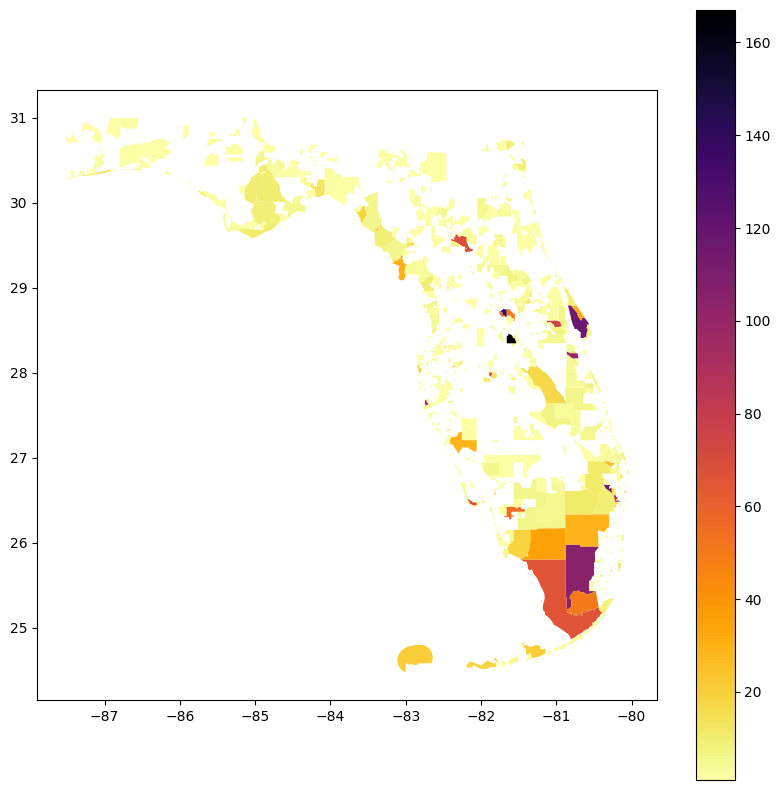

/scratch/local/64522582/ipykernel_3655847/3300049953.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./PUD/PUD_{saveName}.shp', driver='ESRI Shapefile')


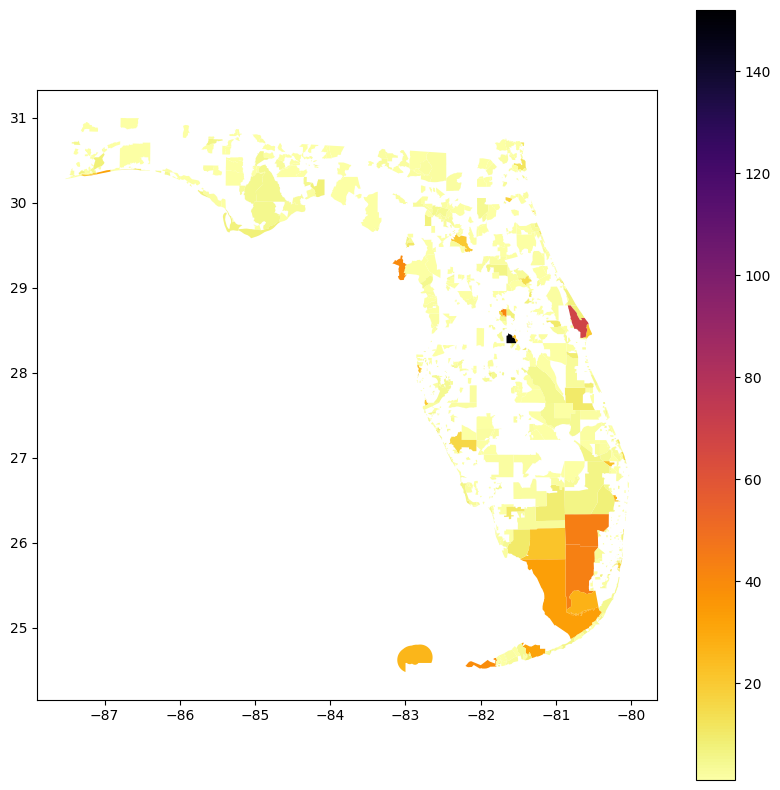

/scratch/local/64522582/ipykernel_3655847/3300049953.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./PUD/PUD_{saveName}.shp', driver='ESRI Shapefile')


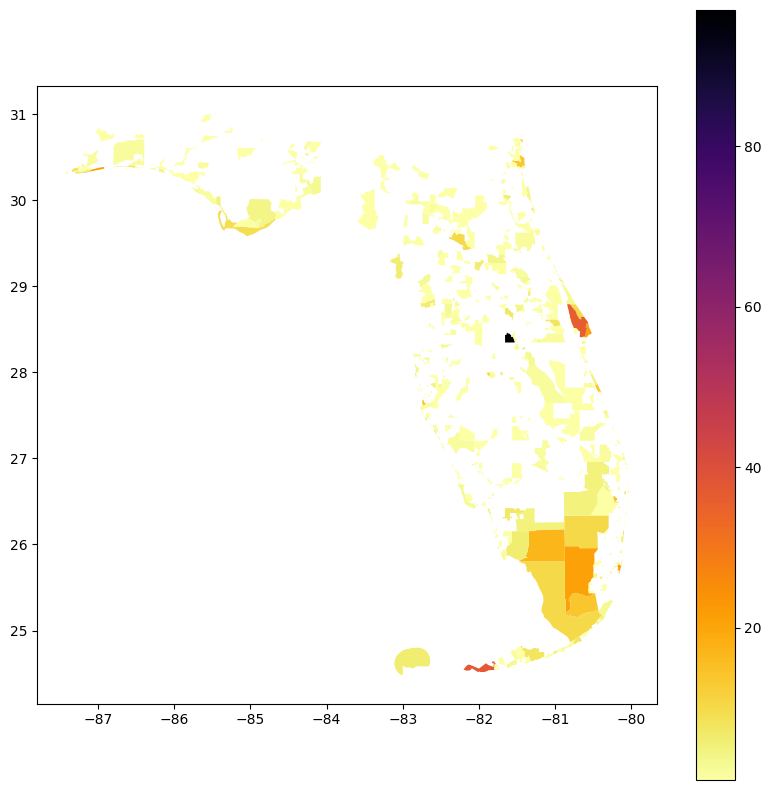

/scratch/local/64522582/ipykernel_3655847/3300049953.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./PUD/PUD_{saveName}.shp', driver='ESRI Shapefile')


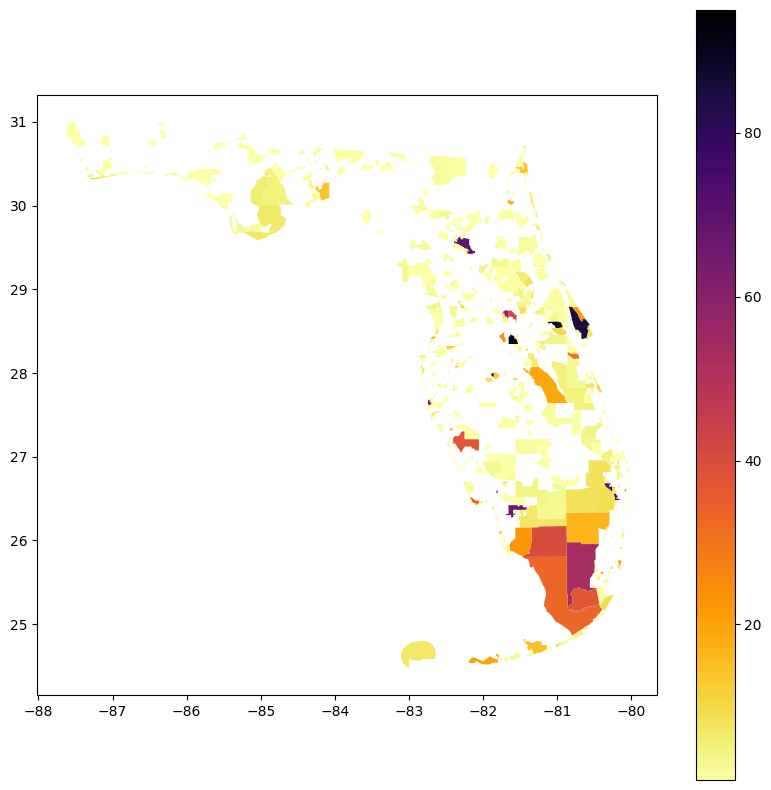

/scratch/local/64522582/ipykernel_3655847/3300049953.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./PUD/PUD_{saveName}.shp', driver='ESRI Shapefile')


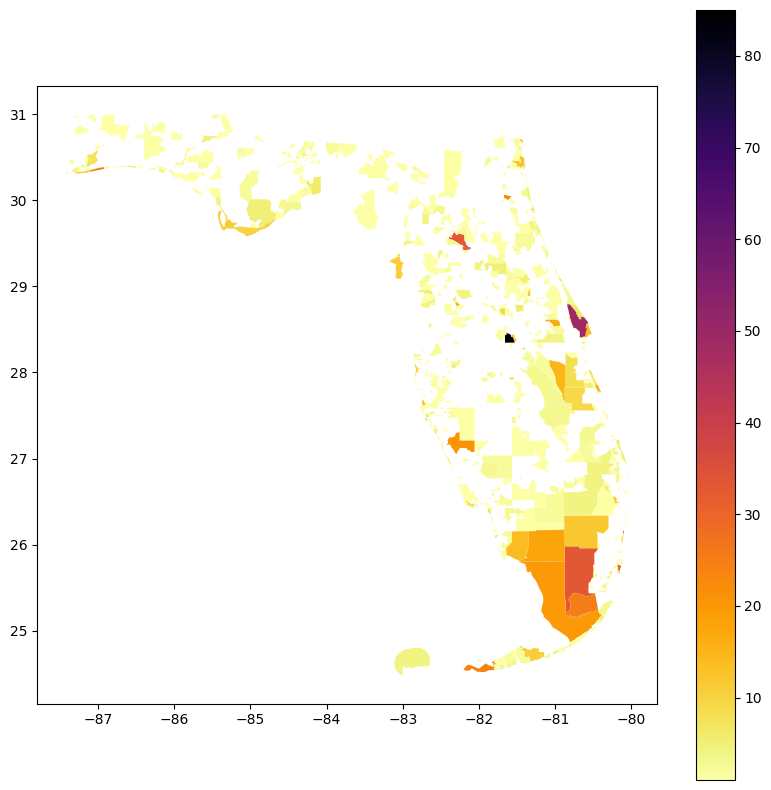

/scratch/local/64522582/ipykernel_3655847/3300049953.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./PUD/PUD_{saveName}.shp', driver='ESRI Shapefile')


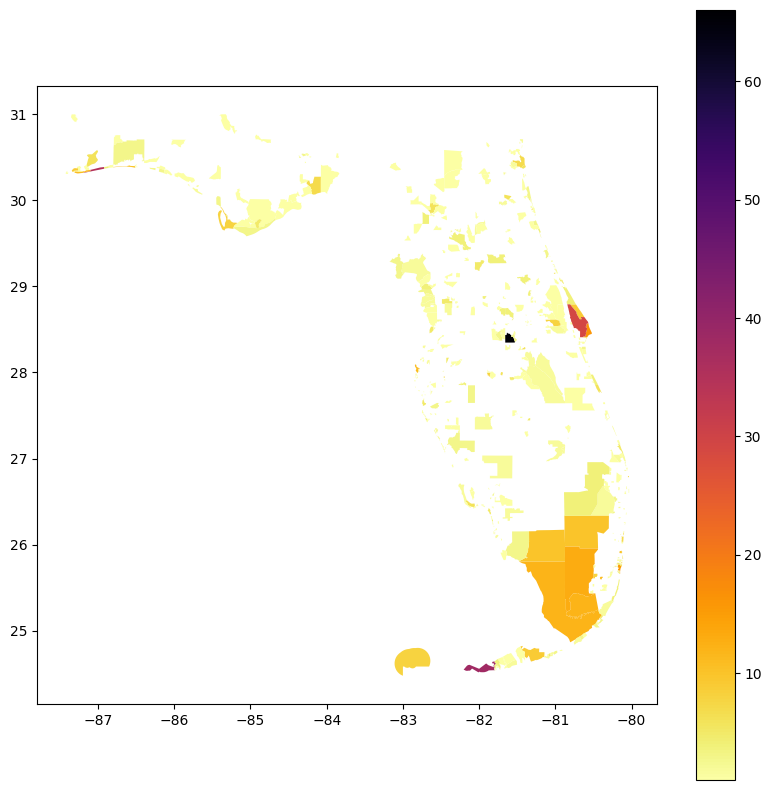

/scratch/local/64522582/ipykernel_3655847/3300049953.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./PUD/PUD_{saveName}.shp', driver='ESRI Shapefile')


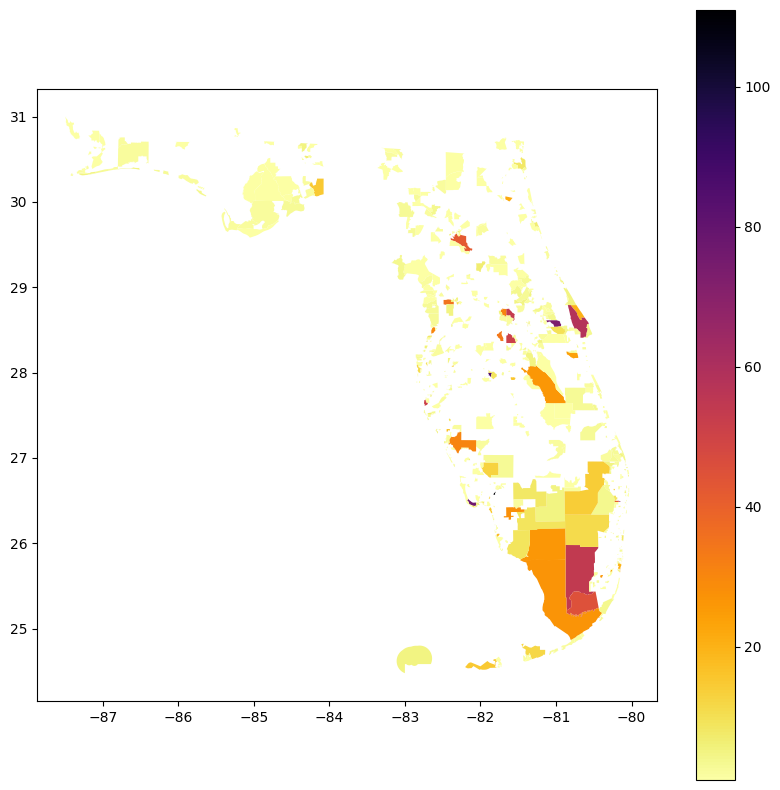

/scratch/local/64522582/ipykernel_3655847/3300049953.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_regions_with_counts.to_file(f'./PUD/PUD_{saveName}.shp', driver='ESRI Shapefile')


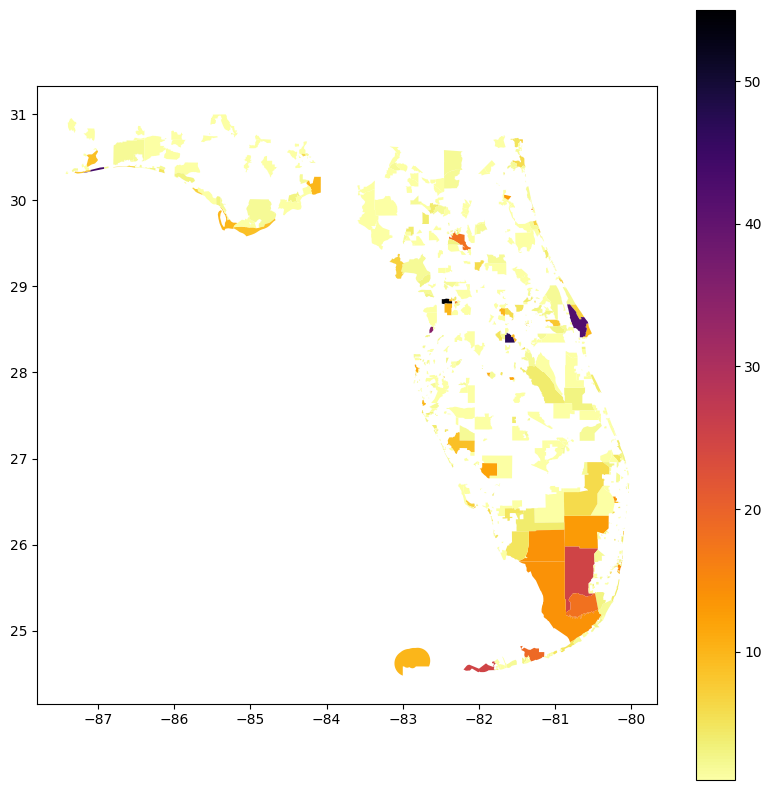

In [38]:
# years_to_filter = [2014, 2015, 2016, 2017, 2018, 2019]
# for year in years_to_filter: #yearly
#     avgPUDsyearly([year], joined_gdf_onlyHumanAct, f'YearlyIntensity_onlyHumanAct_{year}')
#     avgPUDsyearly([year], joined_gdf_wildlife, f'YearlyIntensity_wildlife_{year}')
#     avgPUDsyearly([year], joined_gdf_landscae, f'YearlyIntensity_Landscape_{year}')